# 25. Denoising AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 25.1 Preparing SVHN Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=1,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

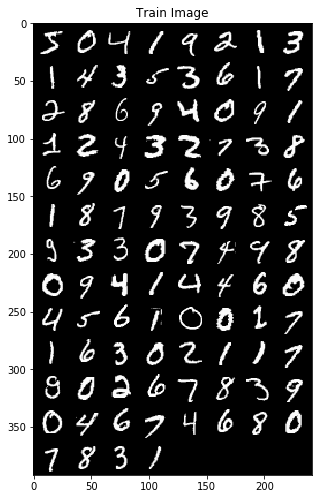

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape

torch.Size([100, 1, 28, 28])

## 25.2 Define Model

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,1,28,28)
        
        return out

In [10]:
E = Encoder().cuda()
D = Decoder().cuda()

## 25.3 Model Training

In [11]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [12]:
num_epochs = 5

In [13]:
for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = Variable(batch_images).cuda()
        
        noise = torch.randn(X.size())*0.1
        noise = Variable(noise).cuda()
        
        noise_X = X + noise
        
        pre = D(E(noise_X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.data[0]))
    
print("Learning Finished!")

Epoch [1/5], lter [100/600] Loss: 0.0222
Epoch [1/5], lter [200/600] Loss: 0.0179
Epoch [1/5], lter [300/600] Loss: 0.0143
Epoch [1/5], lter [400/600] Loss: 0.0112
Epoch [1/5], lter [500/600] Loss: 0.0106
Epoch [1/5], lter [600/600] Loss: 0.0169
Epoch [2/5], lter [100/600] Loss: 0.0086
Epoch [2/5], lter [200/600] Loss: 0.0106
Epoch [2/5], lter [300/600] Loss: 0.0094
Epoch [2/5], lter [400/600] Loss: 0.0079
Epoch [2/5], lter [500/600] Loss: 0.0081
Epoch [2/5], lter [600/600] Loss: 0.0130
Epoch [3/5], lter [100/600] Loss: 0.0069
Epoch [3/5], lter [200/600] Loss: 0.0088
Epoch [3/5], lter [300/600] Loss: 0.0079
Epoch [3/5], lter [400/600] Loss: 0.0068
Epoch [3/5], lter [500/600] Loss: 0.0069
Epoch [3/5], lter [600/600] Loss: 0.0107
Epoch [4/5], lter [100/600] Loss: 0.0061
Epoch [4/5], lter [200/600] Loss: 0.0077
Epoch [4/5], lter [300/600] Loss: 0.0070
Epoch [4/5], lter [400/600] Loss: 0.0061
Epoch [4/5], lter [500/600] Loss: 0.0063
Epoch [4/5], lter [600/600] Loss: 0.0093
Epoch [5/5], lte

## 25.4 Test Model

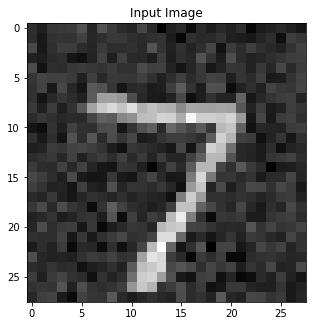

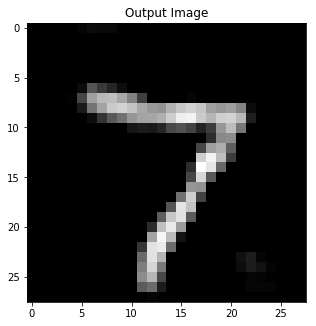

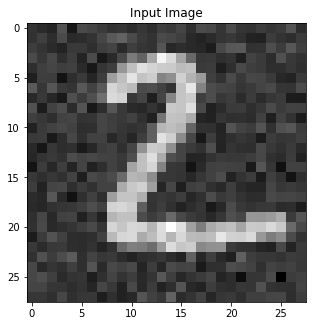

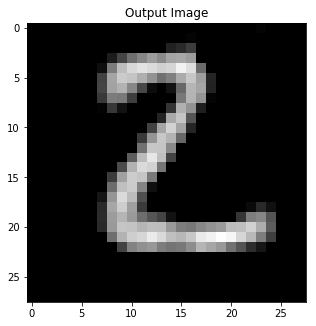

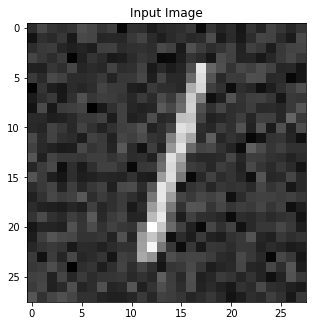

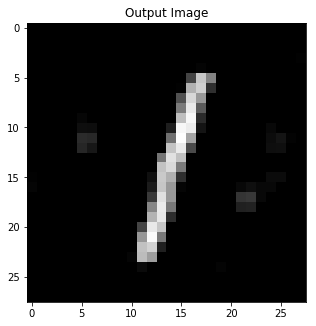

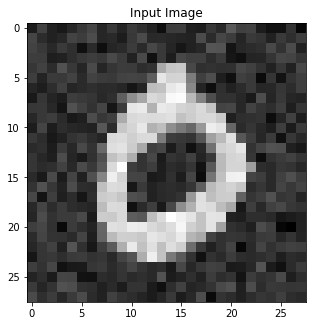

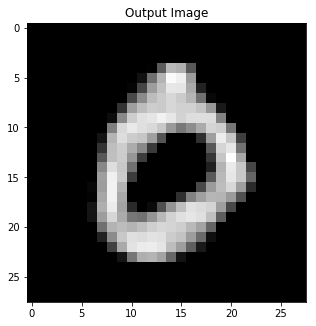

In [20]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    images = Variable(images).cuda()
    
    noise = torch.randn(images.size())*0.1
    noise = Variable(noise).cuda()
    
    noise_images = images + noise
    
    imshow(torchvision.utils.make_grid(noise_images.data.cpu(), normalize=True), "Input Image")
    
    noise_images = noise_images.view(-1, 1, 28, 28)
    
    outputs = D(E(noise_images))
    outputs = outputs.view(-1, 1, 28, 28)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break